In [1]:
%load_ext autoreload
%autoreload 2
%pdb

Automatic pdb calling has been turned ON


In [2]:
import quimb as qu
import quimb.tensor as qtn
import cotengra as ctg

opt = ctg.ReusableHyperOptimizer(
    reconf_opts={},
    max_repeats=16,
    parallel=True,
)

/home/ampolloreno/repos/cotengra/cotengra/hyper.py:29: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


In [6]:
import networkx as nx

In [206]:
import numpy as np
from networkx.algorithms.approximation.vertex_cover import min_weighted_vertex_cover
n = 20
m = int(n/2)
edges = []
while len(edges) < m:
    edge = (np.random.randint(n), np.random.randint(n))
    if edge not in edges and (edge[1], edge[0]) not in edges and edge[0] != edge[1]:
        
        edges.append(edge)
weights = {edge:((np.random.rand(1)-.5)*2)[0] for edge in edges}
# p = n/(n-1)
# g = nx.fast_gnp_random_graph(n, p)
# print(len(min_weighted_vertex_cover(g)), np.sqrt(n))
positive_edges = [edge for edge in edges if weights[edge]>0]

<ipython-input-245-ad46bc30cea9>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([f"{(i-100)/100}" for i in cb.get_ticks()]) #


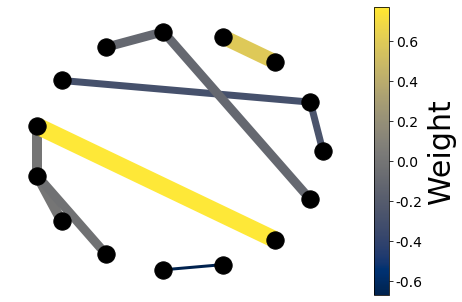

In [245]:
G=nx.Graph()
G.add_weighted_edges_from([(edge[0], edge[1], weights[edge]) for edge in edges])
pos=nx.circular_layout(G)
colors=[int(100+100*weights.get(edge, weights.get((edge[1], edge[0])))) for edge in G.edges]
widths = [int(10+10*weights.get(edge, weights.get((edge[1], edge[0])))) for edge in G.edges]
cmap=plt.cm.cividis
vmin = min(colors)
vmax = max(colors)
nx.draw(G, pos, node_color='k', edge_color=colors, width=widths, edge_cmap=cmap,
           with_labels=False, vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cb= plt.colorbar(sm)
cb.ax.set_yticklabels([f"{(i-100)/100}" for i in cb.get_ticks()]) #
cb.set_label('Weight', fontsize=30)
#plt.show()
tick_font_size = 14
cb.ax.tick_params(labelsize=tick_font_size)
plt.savefig("/home/ampolloreno/graph.png", dpi=200, bbox_inches='tight')


In [146]:
G.edges()

EdgeView([(11, 14), (14, 2), (14, 10), (7, 8), (2, 13), (12, 13), (17, 10), (17, 5), (10, 3), (16, 4)])

ValueError: Invalid RGBA argument: 400

> /home/ampolloreno/anaconda3/envs/qaoa/lib/python3.8/site-packages/matplotlib/colors.py(263)_to_rgba_no_colorcycle()
    261     # tuple color.
    262     if not np.iterable(c):
--> 263         raise ValueError(f"Invalid RGBA argument: {orig_c!r}")
    264     if len(c) not in [3, 4]:
    265         raise ValueError("RGBA sequence should have length 3 or 4")

ipdb> c


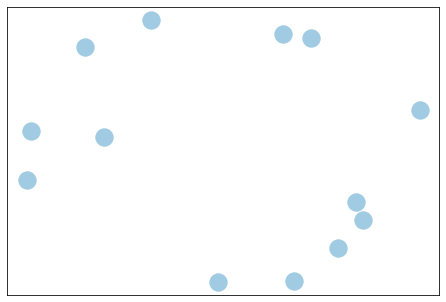

In [ ]:
p = 1
gammas = qu.randn(p)
betas = qu.randn(p)
circ_ex = qtn.circ_qaoa(terms, p, gammas, betas)

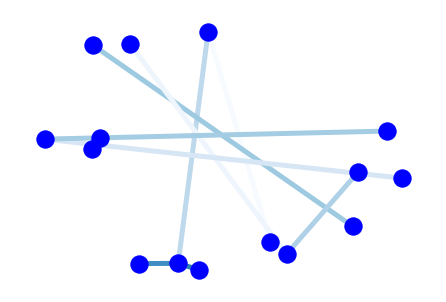

In [111]:
import matplotlib.pyplot as plt
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

pos = nx.spring_layout(G)
nx.draw(G, pos, node_color='b', edgelist=edges, edge_color=weights, width=5.0, edge_cmap=plt.cm.Blues)

In [85]:
from scipy.optimize import dual_annealing
from classical_optimization.qaoa_circuits import execute_qaoa_circuit_and_estimate_cost
import numpy as np
from qiskit import Aer, execute
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model

np.random.seed(666)
reprate = 50 
one_hour = 60 * 60 #seconds
max_gamma = 2 * np.pi
max_beta = np.pi
simulator = Aer.get_backend('qasm_simulator')
noise_model = create_noise_model(cz_fidelity=1)

reg = 3
n = 6
seed = 666
graph = nx.random_regular_graph(reg, n, seed=seed)
graph = nx.watts_strogatz_graph(n, reg, .2, seed=seed)
circ_ex = None

def weights(graph):
    rtn = {}
    for e in graph.edges:
        weight = graph.get_edge_data(e[0], e[1])['weight']
        rtn[e] = weight
    return rtn

def objective(graph):
    #Hack for backwards compatibility.
    num_rows = len(graph.nodes)
    num_cols = 1

    history = []
    def store_log(func):
        def logged_func(x):
            ret = func(x)
            history.append((x, ret))
            return ret
        return logged_func

    @store_log
    def gamma_beta_objective(gamma_beta):
        p = 1
        gammas = [gamma_beta[1]/np.pi]
        betas = [gamma_beta[0]/np.pi]
        terms = {(i, j): 1 for i, j in graph.edges}
        global circ_ex
        if circ_ex is None:
            circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
            circ_ex.sample_rehearse()
        else:
            new_circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
            tm = new_circ_ex.to_dense_tn()
            circ_ex.update_params_from(tm)
        samples = list(circ_ex.sample(shots_per_point))
        values = []
        for sample in samples:
            value = 0
            for k, v in terms.items():
                if sample[k[0]] != sample[k[1]]:
                    value += 1
            values.append(value)
        return np.mean(values)
#         # The cut value is the expectation value, minima of the negation correspond to maxima.
#         return execute_qaoa_circuit_and_estimate_cost(gamma=gamma_beta[1], beta=gamma_beta[0],
#                                                        num_shots=shots_per_point,
#                                                        simulator=simulator,
#                                                        coupling_map=None,
#                                                        weights=weights(graph),
#                                                        rows=num_rows,
#                                                        cols=num_cols,
#                                                        noise_model=noise_model,
#                                                        # Just a fully random seed, in the full range.
#                                                        seed=np.random.randint(0,2**32 - 1))
    return gamma_beta_objective, history



# An annealing attempt on a graph.

In [86]:
from tqdm import tqdm
annealing_attempts = []
shots_per_point = 50
size_attempts = []
func, history = objective(graph)
initial_gamma_beta = [np.random.rand() * max_param for max_param in (max_gamma, max_beta)]
result = dual_annealing(
    lambda x: -1*func(x),
    bounds=[(0, max_gamma),
            (0, max_beta)],
    x0=np.array(initial_gamma_beta),
    # One annealing attempt.
    maxiter=10, # We can remove this later. Just need to be limited by maxfun.
    initial_temp=10,
    maxfun=one_hour*reprate,
    restart_temp_ratio=1E-10,
    no_local_search=True)
result.fun = -result.fun
size_attempts.append((result.x, result.fun))
annealing_attempts.append(size_attempts)
        

In [87]:
annealing_attempts

[[(array([1.90234747, 0.6681665 ]), 3.24)]]

In [88]:
history

[(array([4.40097623, 2.65209056]), 3.08),
 (array([5.63651869, 2.37727625]), 2.56),
 (array([5.77194654, 1.27615701]), 2.76),
 (array([1.54465726, 2.65209056]), 3.0),
 (array([4.40097623, 1.91804652]), 2.48),
 (array([3.0552638 , 1.22803086]), 2.8),
 (array([3.04505806, 0.4948512 ]), 2.52),
 (array([1.23166035, 2.65209056]), 2.92),
 (array([4.40097623, 2.25039801]), 2.72),
 (array([3.55409341, 0.6681665 ]), 3.16),
 (array([3.14330967, 2.01221882]), 2.48),
 (array([0.76053794, 0.6681665 ]), 2.76),
 (array([3.55409341, 1.26159015]), 2.76),
 (array([4.43613166, 2.82831186]), 2.56),
 (array([3.31065888, 0.50448926]), 2.64),
 (array([5.39953392, 0.6681665 ]), 3.0),
 (array([3.55409341, 2.92756559]), 2.44),
 (array([4.73140456, 3.09223542]), 2.76),
 (array([1.39870005, 0.88216444]), 2.76),
 (array([4.3376892, 0.6681665]), 2.72),
 (array([3.55409341, 2.28091365]), 2.4),
 (array([0.60078328, 1.11065911]), 3.0),
 (array([3.02608613, 0.3503525 ]), 2.72),
 (array([1.90234747, 0.6681665 ]), 3.24),

In [89]:
len(graph.edges)

6

In [90]:
# def cutsize(set1, set2, g):
#     cut = 0
#     for s1 in set1:
#         for s2 in set2:
#             if g.get_edge_data(s1, s2) is not None:
#                 if g.get_edge_data(s1, s2) == {}:
#                     cut +=1
#                 else:
#                     cut += g.get_edge_data(s1, s2)['weight']
#     return cut

# def maxcut(g, a=[], b=[], used=[]):
#     for node in g.nodes:
#         if node not in used:
#             left = maxcut(g, list(a) + [node], list(b), list(used) + [node])[0]
#             right = maxcut(g, list(a), list(b) + [node], list(used) + [node])[0]
#             if left > right:
#                 a = list(a) + [node]
#                 b = list(b)
#             else:
#                 a = list(a)
#                 b = list(b) + [node]
#     # There are no unused nodes, we've reached a leaf.
#     return cutsize(a, b, g), a, b
# maxcut(graph)

# An ES attempt on a graph

In [95]:
from es import SimpleGA, CMAES, PEPG, OpenES
# defines OpenAI's ES algorithm solver. Note that we needed to anneal the sigma parameter
NPARAMS = 2
NPOPULATION = 100
oes = OpenES(NPARAMS,                  # number of model parameters
            sigma_init=0.025,            # initial standard deviation
            #sigma_decay=0.99,         # don't anneal standard deviation
            learning_rate=0.005,         # learning rate for standard deviation
            #learning_rate_decay = 0.0, # annealing the learning rate
            popsize=NPOPULATION,       # population size
            #antithetic=False,          # whether to use antithetic sampling
            #weight_decay=0.00,         # weight decay coefficient
            rank_fitness=False)        # use rank rather than fitness numbers
            #forget_best=False)

In [96]:
MAX_ITERATION = 100
fit_func, history = objective(graph)
# defines a function to use solver to solve fit_func
def test_solver(solver):
    history = []
    for j in tqdm(range(MAX_ITERATION)):
        solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)
        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        print(result)
        history.append((result))
        if (j+1) % 100 == 0:
            print("fitness at iteration", (j+1), result[1])
    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return history, result

In [97]:
history, result = test_solver(oes)


  1%|          | 1/100 [00:01<02:09,  1.31s/it]

(array([-0.02605603,  0.03142403]), 3.3599916680664963, 3.3599916680664963, 0.024975)


  2%|▏         | 2/100 [00:02<02:06,  1.29s/it]

(array([0.01368382, 0.02921743]), 3.19999479547628, 3.19999479547628, 0.024950025)


  3%|▎         | 3/100 [00:03<02:03,  1.27s/it]

(array([-0.01447241, -0.01746107]), 3.1599974283023284, 3.1599974283023284, 0.024925074975)


  4%|▍         | 4/100 [00:05<02:02,  1.28s/it]

(array([-0.01854874, -0.00260408]), 3.3199982458143134, 3.3199982458143134, 0.024900149900025)


  5%|▌         | 5/100 [00:06<02:01,  1.28s/it]

(array([0.03788389, 0.02760649]), 3.1999890134627287, 3.1999890134627287, 0.024875249750124975)


  6%|▌         | 6/100 [00:07<01:59,  1.27s/it]

(array([-0.00833748,  0.01128808]), 3.359999015328162, 3.359999015328162, 0.02485037450037485)


  7%|▋         | 7/100 [00:08<01:57,  1.26s/it]

(array([-0.00297414, -0.0484865 ]), 3.279988201069017, 3.279988201069017, 0.024825524125874476)


  8%|▊         | 8/100 [00:10<01:57,  1.28s/it]

(array([ 0.02393005, -0.00839652]), 3.23999678425703, 3.23999678425703, 0.024800698601748602)


  9%|▉         | 9/100 [00:11<01:55,  1.27s/it]

(array([-0.0018121 ,  0.00131007]), 3.1999999749999066, 3.1999999749999066, 0.024775897903146854)


 10%|█         | 10/100 [00:12<01:53,  1.26s/it]

(array([-0.04036568, -0.01104889]), 3.3599912426691785, 3.3599912426691785, 0.02475112200524371)


 11%|█         | 11/100 [00:13<01:53,  1.27s/it]

(array([-0.03556507,  0.01763375]), 3.3599921208834007, 3.3599921208834007, 0.024726370883238466)


 12%|█▏        | 12/100 [00:15<01:52,  1.28s/it]

(array([-0.05903576,  0.01565535]), 3.4799813484434483, 3.4799813484434483, 0.024701644512355226)


 13%|█▎        | 13/100 [00:16<01:50,  1.27s/it]

(array([-0.04902054, -0.01474012]), 3.199986898580467, 3.199986898580467, 0.02467694286784287)


 14%|█▍        | 14/100 [00:17<01:48,  1.26s/it]

(array([-0.0155717, -0.0081507]), 3.2399984554409493, 3.2399984554409493, 0.024652265924975027)


 15%|█▌        | 15/100 [00:19<01:51,  1.31s/it]

(array([ 0.02803627, -0.02253478]), 3.239993530756199, 3.239993530756199, 0.02462761365905005)


 16%|█▌        | 16/100 [00:20<01:48,  1.29s/it]

(array([-0.04320264, -0.0377434 ]), 3.19998354483594, 3.19998354483594, 0.024602986045391)


 17%|█▋        | 17/100 [00:21<01:45,  1.28s/it]

(array([-0.02581894, -0.02546773]), 3.199993423885389, 3.199993423885389, 0.02457838305934561)


 18%|█▊        | 18/100 [00:22<01:44,  1.28s/it]

(array([0.01745576, 0.00042842]), 3.239998475564415, 3.239998475564415, 0.024553804676286265)


 19%|█▉        | 19/100 [00:24<01:43,  1.28s/it]

(array([-0.03340617, -0.07760775]), 3.1599643053272803, 3.1599643053272803, 0.024529250871609978)


 20%|██        | 20/100 [00:25<01:41,  1.27s/it]

(array([ 0.0099719 , -0.04387747]), 3.3599898766432865, 3.3599898766432865, 0.024504721620738367)


 21%|██        | 21/100 [00:26<01:40,  1.27s/it]

(array([-0.00550631, -0.01979794]), 3.2399978886098744, 3.2399978886098744, 0.02448021689911763)


 22%|██▏       | 22/100 [00:27<01:38,  1.27s/it]

(array([-0.03028855, -0.01569765]), 3.279994180938186, 3.279994180938186, 0.024455736682218513)


 23%|██▎       | 23/100 [00:29<01:38,  1.27s/it]

(array([-0.02580184, -0.03192812]), 3.2799915743037182, 3.2799915743037182, 0.024431280945536295)


 24%|██▍       | 24/100 [00:30<01:36,  1.27s/it]

(array([-0.03599408, -0.02227376]), 3.3599910415308134, 3.3599910415308134, 0.02440684966459076)


 25%|██▌       | 25/100 [00:31<01:35,  1.27s/it]

(array([-0.00308331, -0.01138714]), 3.1599993041317456, 3.1599993041317456, 0.02438244281492617)


 26%|██▌       | 26/100 [00:33<01:33,  1.27s/it]

(array([ 0.00311893, -0.01777356]), 3.1199983718640367, 3.1199983718640367, 0.024358060372111242)


 27%|██▋       | 27/100 [00:34<01:32,  1.27s/it]

(array([-0.00562422, -0.0022354 ]), 3.2799998168556233, 3.2799998168556233, 0.02433370231173913)


 28%|██▊       | 28/100 [00:35<01:32,  1.28s/it]

(array([-0.0297411 ,  0.01317991]), 3.2799947087838017, 3.2799947087838017, 0.024309368609427392)


 29%|██▉       | 29/100 [00:36<01:30,  1.27s/it]

(array([ 0.01020994, -0.0359621 ]), 3.1999930124212352, 3.1999930124212352, 0.024285059240817964)


 30%|███       | 30/100 [00:38<01:29,  1.28s/it]

(array([-0.01596043, -0.0272107 ]), 3.4399950242138337, 3.4399950242138337, 0.024260774181577145)


 31%|███       | 31/100 [00:39<01:29,  1.29s/it]

(array([-0.03167077, -0.01451852]), 3.1599939308734655, 3.1599939308734655, 0.024236513407395566)


 32%|███▏      | 32/100 [00:40<01:27,  1.29s/it]

(array([-0.0358912 , -0.03400411]), 3.1599877777135235, 3.1599877777135235, 0.02421227689398817)


 33%|███▎      | 33/100 [00:42<01:26,  1.29s/it]

(array([-0.020067  ,  0.01380099]), 3.2799970342407327, 3.2799970342407327, 0.02418806461709418)


 34%|███▍      | 34/100 [00:43<01:25,  1.30s/it]

(array([-0.03285489,  0.01194099]), 3.359993889844651, 3.359993889844651, 0.024163876552477086)


 35%|███▌      | 35/100 [00:44<01:24,  1.31s/it]

(array([-0.0498406 ,  0.02670065]), 3.2799840149491475, 3.2799840149491475, 0.02413971267592461)


 36%|███▌      | 36/100 [00:46<01:23,  1.30s/it]

(array([-0.03303099, -0.0337435 ]), 3.239988851649284, 3.239988851649284, 0.024115572963248684)


 37%|███▋      | 37/100 [00:47<01:21,  1.29s/it]

(array([-0.04884465, -0.03795575]), 3.3999808678084236, 3.3999808678084236, 0.024091457390285436)


 38%|███▊      | 38/100 [00:48<01:19,  1.27s/it]

(array([-0.03683019, -0.00891821]), 3.3599928200117786, 3.3599928200117786, 0.02406736593289515)


 39%|███▉      | 39/100 [00:49<01:17,  1.27s/it]

(array([-0.01430675, -0.00638389]), 3.3199987728146976, 3.3199987728146976, 0.024043298566962256)


 40%|████      | 40/100 [00:51<01:15,  1.26s/it]

(array([-0.02831481,  0.02247149]), 3.2799934665186785, 3.2799934665186785, 0.024019255268395295)


 41%|████      | 41/100 [00:52<01:15,  1.28s/it]

(array([-0.05603179, -0.01449433]), 3.3599832517617743, 3.3599832517617743, 0.0239952360131269)


 42%|████▏     | 42/100 [00:53<01:14,  1.28s/it]

(array([-0.04545493, -0.06807451]), 3.3199664985533337, 3.3199664985533337, 0.02397124077711377)


 43%|████▎     | 43/100 [00:54<01:13,  1.29s/it]

(array([-0.0393187 , -0.01518678]), 3.319991117006227, 3.319991117006227, 0.023947269536336656)


 44%|████▍     | 44/100 [00:56<01:12,  1.29s/it]

(array([-0.06659309,  0.02623204]), 3.3199743861985462, 3.3199743861985462, 0.02392332226680032)


 45%|████▌     | 45/100 [00:57<01:10,  1.29s/it]

(array([-0.06850601, -0.05233565]), 3.2799628395283142, 3.2799628395283142, 0.02389939894453352)


 46%|████▌     | 46/100 [00:58<01:09,  1.30s/it]

(array([-0.07822982, -0.02054644]), 3.279967289695215, 3.279967289695215, 0.023875499545588985)


 47%|████▋     | 47/100 [01:00<01:12,  1.36s/it]

(array([-0.03886844, -0.03011657]), 3.1599879111824847, 3.1599879111824847, 0.023851624046043397)


 48%|████▊     | 48/100 [01:01<01:09,  1.34s/it]

(array([-0.07088894, -0.0243861 ]), 3.239971900380662, 3.239971900380662, 0.023827772421997354)


 49%|████▉     | 49/100 [01:02<01:07,  1.32s/it]

(array([-0.07852736, -0.05161306]), 3.2399558477273267, 3.2399558477273267, 0.023803944649575356)


 50%|█████     | 50/100 [01:04<01:04,  1.30s/it]

(array([-0.06734788, -0.03076339]), 3.159972589384914, 3.159972589384914, 0.02378014070492578)


 51%|█████     | 51/100 [01:05<01:03,  1.29s/it]

(array([-0.03903373, -0.03138006]), 3.2399874582998285, 3.2399874582998285, 0.023756360564220855)


 52%|█████▏    | 52/100 [01:06<01:01,  1.29s/it]

(array([-0.06402279,  0.01609167]), 3.279978210700641, 3.279978210700641, 0.023732604203656634)


 53%|█████▎    | 53/100 [01:08<01:01,  1.31s/it]

(array([-0.05619283, -0.05574002]), 3.2399686770827754, 3.2399686770827754, 0.023708871599452976)


 54%|█████▍    | 54/100 [01:09<01:02,  1.35s/it]

(array([-0.07631796, -0.0341618 ]), 3.3599650427041436, 3.3599650427041436, 0.023685162727853523)


 55%|█████▌    | 55/100 [01:10<00:59,  1.33s/it]

(array([-0.05778375, -0.01984877]), 3.2399813353229074, 3.2399813353229074, 0.02366147756512567)


 56%|█████▌    | 56/100 [01:12<00:57,  1.31s/it]

(array([-0.01538502,  0.01926244]), 3.2399969612985458, 3.2399969612985458, 0.023637816087560545)


 57%|█████▋    | 57/100 [01:13<00:56,  1.31s/it]

(array([-0.0830711 , -0.02197534]), 3.1999630813874265, 3.1999630813874265, 0.023614178271472983)


 58%|█████▊    | 58/100 [01:14<00:57,  1.38s/it]

(array([-0.04184251,  0.00849688]), 3.3199908850375026, 3.3199908850375026, 0.02359056409320151)


 59%|█████▉    | 59/100 [01:16<00:55,  1.35s/it]

(array([-0.03994658, -0.03153728]), 3.3199870483568366, 3.3199870483568366, 0.023566973529108307)


 60%|██████    | 60/100 [01:17<00:53,  1.33s/it]

(array([-0.06973915, -0.0230105 ]), 3.31997303484196, 3.31997303484196, 0.0235434065555792)


 61%|██████    | 61/100 [01:18<00:52,  1.33s/it]

(array([-0.07277535, -0.0165442 ]), 3.3199721501894275, 3.3199721501894275, 0.023519863149023622)


 62%|██████▏   | 62/100 [01:20<00:50,  1.33s/it]

(array([-0.0279399 , -0.01584342]), 3.199994841741896, 3.199994841741896, 0.023496343285874598)


 63%|██████▎   | 63/100 [01:21<00:49,  1.33s/it]

(array([-0.02796066, -0.01951193]), 3.279994187431071, 3.279994187431071, 0.023472846942588724)


 64%|██████▍   | 64/100 [01:22<00:49,  1.38s/it]

(array([-0.06958658, -0.01880855]), 3.1599740197308273, 3.1599740197308273, 0.023449374095646135)


 65%|██████▌   | 65/100 [01:24<00:47,  1.35s/it]

(array([-0.08562679, -0.00311109]), 3.2799632918705286, 3.2799632918705286, 0.02342592472155049)


 66%|██████▌   | 66/100 [01:25<00:48,  1.41s/it]

(array([-0.07786223, -0.03744395]), 3.319962677117257, 3.319962677117257, 0.02340249879682894)


 67%|██████▋   | 67/100 [01:27<00:45,  1.38s/it]

(array([-0.10569476, -0.01421499]), 3.2399431327550032, 3.2399431327550032, 0.02337909629803211)


 68%|██████▊   | 68/100 [01:28<00:43,  1.35s/it]

(array([-0.0839816 , -0.02673917]), 3.2799611605365, 3.2799611605365, 0.02335571720173408)


 69%|██████▉   | 69/100 [01:29<00:41,  1.35s/it]

(array([-0.09302391, -0.00410293]), 3.239956648586309, 3.239956648586309, 0.023332361484532344)


 70%|███████   | 70/100 [01:30<00:39,  1.31s/it]

(array([-0.04866909, -0.02534786]), 3.1199849440308918, 3.1199849440308918, 0.023309029123047813)


 71%|███████   | 71/100 [01:32<00:38,  1.31s/it]

(array([-0.09810204, -0.011063  ]), 3.1599512680024757, 3.1599512680024757, 0.023285720093924767)


 72%|███████▏  | 72/100 [01:33<00:37,  1.32s/it]

(array([-0.06201564,  0.02055986]), 3.1599786567611856, 3.1599786567611856, 0.023262434373830843)


 73%|███████▎  | 73/100 [01:34<00:35,  1.32s/it]

(array([-0.07829839,  0.00980062]), 3.2399688665469344, 3.2399688665469344, 0.02323917193945701)


 74%|███████▍  | 74/100 [01:36<00:34,  1.31s/it]

(array([-0.03993556, -0.03724711]), 3.1999850890173804, 3.1999850890173804, 0.023215932767517555)


 75%|███████▌  | 75/100 [01:37<00:32,  1.30s/it]

(array([-0.07728845, -0.01168598]), 3.199969449668662, 3.199969449668662, 0.02319271683475004)


 76%|███████▌  | 76/100 [01:38<00:31,  1.29s/it]

(array([-0.08461691, -0.01491009]), 3.159963088342071, 3.159963088342071, 0.02316952411791529)


 77%|███████▋  | 77/100 [01:40<00:29,  1.28s/it]

(array([-0.06945884,  0.01399776]), 3.2799748976608996, 3.2799748976608996, 0.023146354593797373)


 78%|███████▊  | 78/100 [01:41<00:27,  1.26s/it]

(array([-0.07973381, -0.01291042]), 3.1599673792058094, 3.1599673792058094, 0.023123208239203576)


 79%|███████▉  | 79/100 [01:42<00:26,  1.25s/it]

(array([-0.07990158, -0.01102947]), 3.3999674704452802, 3.3999674704452802, 0.023100085030964373)


 80%|████████  | 80/100 [01:43<00:24,  1.25s/it]

(array([-0.04723511, -0.01417575]), 3.1599878394614414, 3.1599878394614414, 0.02307698494593341)


 81%|████████  | 81/100 [01:44<00:23,  1.24s/it]

(array([-0.11310999, -0.04092984]), 3.239927654397157, 3.239927654397157, 0.023053907960987476)


 82%|████████▏ | 82/100 [01:46<00:22,  1.24s/it]

(array([-0.09956063, -0.01283878]), 3.279949614229314, 3.279949614229314, 0.02303085405302649)


 83%|████████▎ | 83/100 [01:47<00:21,  1.24s/it]

(array([-0.09838164, -0.02315582]), 3.199948924308518, 3.199948924308518, 0.023007823198973463)


 84%|████████▍ | 84/100 [01:48<00:19,  1.24s/it]

(array([-0.0241863 , -0.01858923]), 3.19999534731586, 3.19999534731586, 0.02298481537577449)


 85%|████████▌ | 85/100 [01:49<00:18,  1.24s/it]

(array([-0.04899143, -0.03983246]), 3.2799800660751353, 3.2799800660751353, 0.022961830560398716)


 86%|████████▌ | 86/100 [01:51<00:17,  1.24s/it]

(array([-0.04703595, -0.01059644]), 3.199988376676227, 3.199988376676227, 0.022938868729838316)


 87%|████████▋ | 87/100 [01:52<00:16,  1.25s/it]

(array([-0.06144731,  0.00395242]), 3.1599810430325403, 3.1599810430325403, 0.022915929861108478)


 88%|████████▊ | 88/100 [01:53<00:15,  1.26s/it]

(array([-0.09627172,  0.02319441]), 3.2399509688785013, 3.2399509688785013, 0.022893013931247368)


 89%|████████▉ | 89/100 [01:55<00:14,  1.28s/it]

(array([-0.12984562, -0.04350276]), 3.23990623812087, 3.23990623812087, 0.02287012091731612)


 90%|█████████ | 90/100 [01:56<00:12,  1.29s/it]

(array([-0.04961456, -0.01685821]), 3.3199862709792973, 3.3199862709792973, 0.022847250796398804)


 91%|█████████ | 91/100 [01:57<00:11,  1.33s/it]

(array([-0.03887542,  0.03813137]), 3.199985173501581, 3.199985173501581, 0.022824403545602404)


 92%|█████████▏| 92/100 [01:59<00:10,  1.31s/it]

(array([-0.07174006, -0.03293689]), 3.1999688426236035, 3.1999688426236035, 0.022801579142056803)


 93%|█████████▎| 93/100 [02:00<00:09,  1.29s/it]

(array([-0.06799106, -0.03937334]), 3.279969134777307, 3.279969134777307, 0.022778777562914746)


 94%|█████████▍| 94/100 [02:01<00:07,  1.29s/it]

(array([-0.06161711, -0.01716293]), 3.1599795438255667, 3.1599795438255667, 0.02275599878535183)


 95%|█████████▌| 95/100 [02:02<00:06,  1.29s/it]

(array([-0.04681993, -0.01690012]), 3.279987611398012, 3.279987611398012, 0.02273324278656648)


 96%|█████████▌| 96/100 [02:04<00:05,  1.30s/it]

(array([-0.06855515, -0.01522921]), 3.2799753413121264, 3.2799753413121264, 0.022710509543779914)


 97%|█████████▋| 97/100 [02:05<00:03,  1.29s/it]

(array([-0.07870855,  0.02061789]), 3.1999668993344645, 3.1999668993344645, 0.022687799034236133)


 98%|█████████▊| 98/100 [02:06<00:02,  1.29s/it]

(array([-0.08474114, -0.01052005]), 3.3199635413362163, 3.3199635413362163, 0.022665111235201898)


 99%|█████████▉| 99/100 [02:08<00:01,  1.29s/it]

(array([-0.03388287,  0.02698279]), 3.1999906194032177, 3.1999906194032177, 0.022642446123966695)


100%|██████████| 100/100 [02:09<00:00,  1.29s/it]

(array([-0.05700351, -0.011353  ]), 3.1999831085450956, 3.1999831085450956, 0.022619803677842727)
fitness at iteration 100 3.1999831085450956
local optimum discovered by solver:
 [-0.05700351 -0.011353  ]
fitness score at this local optimum: 3.1999831085450956


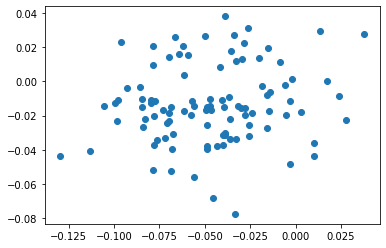

In [101]:
xys = [h[0] for h in history]
x = [el[0] for el in xys]
y = [el[1] for el in xys]
plt.scatter(x, y)

In [ ]:
MAX_ITERATION = 500
reg = 3
n = 10
seed = 666
graph = nx.random_regular_graph(reg, n, seed=seed)

In [ ]:
history

In [ ]:
# It's currently reporting the average fitness, which of course it might want to use when it's estimating the energy
# But at the end it should report the maximum value. Here the mean is 10.1, which suggests that a better bitstring was 
# sampled.

# Compute Maxcut of Graphs

In [ ]:
def cutsize(set1, set2, g):
    cut = 0
    for s1 in set1:
        for s2 in set2:
            if g.get_edge_data(s1, s2) is not None:
                cut += g.get_edge_data(s1, s2)['weight']
    return cut

def maxcut(g, a=[], b=[], used=[]):
    for node in g.nodes:
        if node not in used:
            left = maxcut(g, list(a) + [node], list(b), list(used) + [node])[0]
            right = maxcut(g, list(a), list(b) + [node], list(used) + [node])[0]
            if left > right:
                a = list(a) + [node]
                b = list(b)
            else:
                a = list(a)
                b = list(b) + [node]
    # There are no unused nodes, we've reached a leaf.
    return cutsize(a, b, g), a, b

maxcuts = []
for size in tqdm(graph_sizes[:1]):
    size_landscapes = []
    for graph in size[:1]:
        size_landscapes.append(maxcut(graph))
    maxcuts.append(size_landscapes)

In [ ]:
maxcuts

# Compute Maximum Landscape Value for Concentration

In [ ]:
from classical_optimization.qaoa_circuits import plot_landscape
import matplotlib.pyplot as plt
maxargs = []
for size in tqdm(landscapes[:1]):
    size_args = []
    for landscape in size[:1]:
        size_args.append((np.argmax(landscape), np.max(landscape)))
    maxargs.append(size_args)

In [ ]:
maxargs